# Analysis of Alabama


## Required Packages

In [6]:
# For working with graphs
import networkx as nx
# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrchain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# So everyone uses the same randomness
import random

import maup


Read the shapefile data into a geodata frame and a graph.

In [7]:
# Read shapefile data into a geo data frame and a graph
al_gdf = gpd.read_file("al_precinct_file/Alabama_precincts_with_data.shp")
al_graph = Graph.from_file("al_precinct_file/Alabama_precincts_with_data.shp", ignore_errors=True)

/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/gerrychain/graph/adjacency.py:112: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(1805, 1814), (1776, 1787), (99, 100), (274, 1044), (687, 697), (1178, 1182), (1787, 1802), (1798, 1802), (1806, 1815), (949, 953), (369, 378), (449, 725), (1827, 1838), (1830, 1843), (1569, 1579), (709, 730), (977, 1048), (386, 952), (1580, 1588), (797, 1099), (181, 1495), (1804, 1827), (1097, 1220), (154, 166), (80, 378), (229, 367), (513, 1685), (1780, 1789), (1793, 1817), (1816, 1819), (225, 235), (687, 1074), (272, 1070), (1794, 1809), (183, 1806), (158, 172), (365, 385), (183, 1815), (457, 468), (1476, 1490), (276, 304), (105, 175), (269, 277), (1806, 1810), (77, 85), (953, 1476), (316, 1926), (310, 1855), (469, 698), (302, 1106), (469, 716), (1532, 1534), (302, 1115), (472, 1792), (1167, 1274), (1789, 1824), (1823, 1835), (702, 704), (690, 711), (501, 543), (246, 253), (1774, 1808), (1782, 1821), (545, 558), (294,

In [ ]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

senate_columns = ["G22USSDBOY", "G22USSLSOP", "G22USSOWRI", "G22USSRBRI"]

al_gdf.rename(columns={'OriginalPl': 'Original_CD', "AdoptedPla": "Adopted_CD", "P1_001N": "Total Population", "P1_002N": "One Race Population", "P1_003N": "White", "P1_004N": "Black", "P1_005N": "Native", "P1_006N": "Asian", "P1_007N": "Pacific Islander", "P1_008N": "Other"}, inplace=True)

print(al_gdf.columns)

al_graph = Graph.from_geodataframe(al_gdf, ignore_errors=True)

Index(['UNIQUE_ID', 'COUNTYFP', 'County', 'Precinct', 'G22USSDBOY',
       'G22USSLSOP', 'G22USSOWRI', 'G22USSRBRI', 'Original_CD', 'Adopted_CD',
       'Total Population', 'One Race Population', 'White', 'Black', 'Native',
       'Asian', 'Pacific Islander', 'Other', 'geometry'],
      dtype='object')


/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/gerrychain/graph/adjacency.py:112: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(1805, 1814), (1776, 1787), (99, 100), (274, 1044), (687, 697), (1178, 1182), (1787, 1802), (1798, 1802), (1806, 1815), (949, 953), (369, 378), (449, 725), (1827, 1838), (1830, 1843), (1569, 1579), (709, 730), (977, 1048), (386, 952), (1580, 1588), (797, 1099), (181, 1495), (1804, 1827), (1097, 1220), (154, 166), (80, 378), (229, 367), (513, 1685), (1780, 1789), (1793, 1817), (1816, 1819), (225, 235), (687, 1074), (272, 1070), (1794, 1809), (183, 1806), (158, 172), (365, 385), (183, 1815), (457, 468), (1476, 1490), (276, 304), (105, 175), (269, 277), (1806, 1810), (77, 85), (953, 1476), (316, 1926), (310, 1855), (469, 698), (302, 1106), (469, 716), (1532, 1534), (302, 1115), (472, 1792), (1167, 1274), (1789, 1824), (1823, 1835), (702, 704), (690, 711), (501, 543), (246, 253), (1774, 1808), (1782, 1821), (545, 558), (294,

<Axes: >

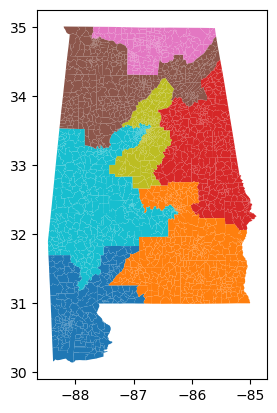

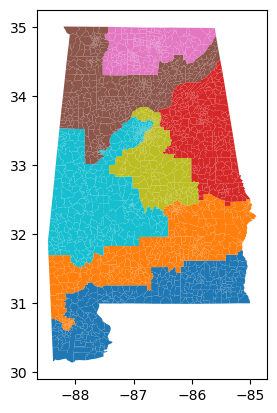

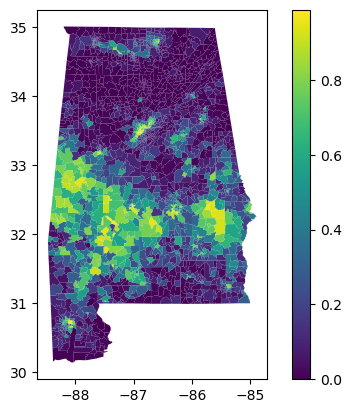

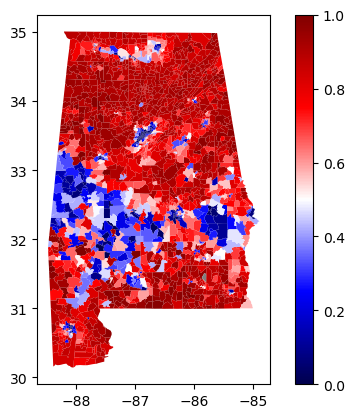

In [12]:
# Make a distrcting plan, using the CD column
original_plan = GeographicPartition(al_graph, assignment = "Original_CD")

# Draw the map of the districting plan
al_gdf.plot(column = 'Original_CD', cmap = 'tab10')

# Draw the map of the new districting plan
al_gdf.plot(column = "Adopted_CD", cmap = 'tab10')

# Plot the black population percentage by precincts
al_gdf['b_frac'] = pd.to_numeric(al_gdf['Black'])/pd.to_numeric(al_gdf['Total Population'])
al_gdf.plot(column = 'b_frac', missing_kwds = {"color":"grey"}, legend=True)

# Color units based on Democratic majority

# Plot the senate republican votes by precincts
al_gdf['pref_party'] = pd.to_numeric(al_gdf['G22USSRBRI'])/pd.to_numeric(al_gdf["G22USSDBOY"] + al_gdf["G22USSLSOP"] + al_gdf["G22USSOWRI"] + al_gdf["G22USSRBRI"])
al_gdf.plot(column = 'pref_party', missing_kwds = {"color":"grey"}, cmap = "seismic", legend=True)

In [13]:
# Get the information at the Nodes
print("Information at Nodes: ", al_graph.nodes()[0].keys())
# Get the total population of Massachusetts
tot_pop = sum([al_graph.nodes()[v]['Total Population'] for v in al_graph.nodes()])
print("Total Population: ", tot_pop)

Information at Nodes:  dict_keys(['boundary_node', 'area', 'UNIQUE_ID', 'COUNTYFP', 'County', 'Precinct', 'G22USSDBOY', 'G22USSLSOP', 'G22USSOWRI', 'G22USSRBRI', 'Original_CD', 'Adopted_CD', 'Total Population', 'One Race Population', 'White', 'Black', 'Native', 'Asian', 'Pacific Islander', 'Other', 'geometry'])
Total Population:  5024279


In [15]:
num_dist = 7 # Number of Congressional Districts in Alabama
ideal_pop = tot_pop/num_dist #tot_pop is calculated in the previous cell
pop_tolerance = 0.02 #how much variance we want in the population of each district
initial_plan = recursive_tree_part(al_graph, range(num_dist), ideal_pop, 'Total Population', pop_tolerance, 10) #use recursive tree part to create an initial plan

In [17]:
# create the 2011 plan
originalPlan = GeographicPartition(al_graph, assignment = "Original_CD")

# confirm that this worked
print(originalPlan)

<GeographicPartition [7 parts]>


In [18]:
# create the initial partition
initial_partition = Partition(
    al_graph,
    assignment = originalPlan.assignment,
    updaters = 
    {   "cut edges": cut_edges ,
        "district population": Tally("Total Population", alias = "district population"),
        "district BPOP": Tally("Black", alias = "district BPOP"),
        "R Votes": Tally("G22USSRBRI", alias = "R Votes"), 
        "D Votes": Tally("G22USSDBOY", alias = "D Votes"),
    }
)

In [19]:
# What does a partition object look like when you print it? 
print(initial_partition)

<Partition [7 parts]>


In [21]:
# How many democratic districts does our initial plan have?
d = 0
for i in range(num_dist): 
    if initial_partition["R Votes"][i] < initial_partition["D Votes"][i]:
        d += 1

print("Number of Democratic Districts: ", d)


Number of Democratic Districts:  1


In [27]:
# how to take a step
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "Total Population", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [28]:
# We need to ensure that there is a population constraint
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [35]:
ma_random_walk = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 10000
)

In [36]:
# Now run it!
cutedge_ensemble = []
bmaj_ensemble = []
d_ensemble = [] 

for part in ma_random_walk:
    # Add cutedges to cutedges ensemble
    cutedge_ensemble.append(len(part["cut edges"]))
    
    # Calculate number of Districts with at least 10 BPOP%
    # Add to ensemble
    num_maj_black = 0
    for i in range(num_dist):
        b_perc = part["district BPOP"][i]/part["district population"][i]
        if b_perc >= 0.5: 
            num_maj_black = num_maj_black + 1
    bmaj_ensemble.append(num_maj_black)

    # Calculate number of districts with more Democratic votes than Republican votes
    d = 0
    for i in range(num_dist):
        if part["R Votes"][i] < part["D Votes"][i]: 
            d = d + 1
    d_ensemble.append(d)
    
print(cutedge_ensemble)
print(bmaj_ensemble)
print(d_ensemble)

[432, 386, 397, 424, 408, 418, 452, 450, 449, 439, 428, 408, 408, 414, 420, 416, 409, 410, 413, 422, 429, 422, 429, 421, 412, 412, 420, 428, 428, 412, 427, 410, 404, 392, 367, 394, 396, 368, 354, 351, 365, 370, 368, 380, 409, 418, 440, 438, 421, 448, 433, 423, 406, 412, 425, 445, 442, 421, 399, 395, 391, 408, 406, 412, 421, 418, 408, 401, 417, 409, 397, 408, 401, 408, 402, 397, 402, 407, 423, 417, 415, 405, 390, 400, 398, 430, 425, 403, 397, 428, 463, 449, 448, 470, 476, 489, 478, 467, 454, 429, 419, 440, 389, 383, 385, 382, 390, 373, 367, 363, 362, 358, 358, 354, 371, 371, 391, 382, 390, 381, 383, 377, 386, 402, 403, 401, 410, 408, 397, 385, 374, 375, 380, 390, 424, 442, 438, 463, 476, 467, 442, 401, 402, 436, 414, 424, 426, 427, 410, 410, 408, 401, 402, 397, 392, 432, 452, 443, 395, 362, 368, 391, 411, 411, 413, 396, 396, 366, 375, 416, 400, 370, 385, 369, 363, 383, 367, 369, 353, 360, 382, 408, 421, 441, 441, 426, 428, 421, 412, 454, 400, 382, 387, 386, 404, 403, 421, 440, 433, 401,

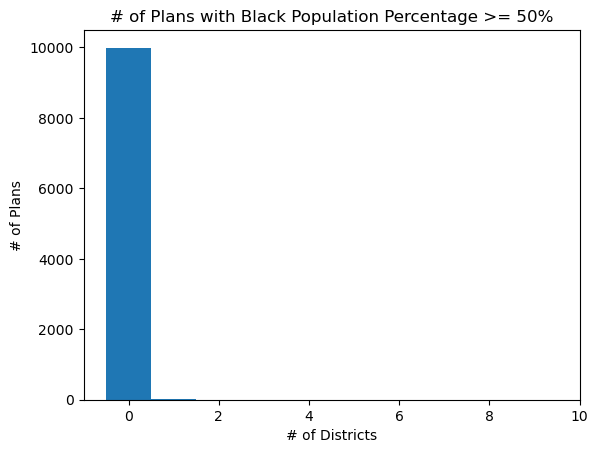

In [39]:
plt.figure()
plt.hist(bmaj_ensemble, align = 'left', bins = [0,1,2,3,4,5,6,7,8,9,10])
plt.title("# of Plans with Black Population Percentage >= 50%")
plt.xlabel("# of Districts")
plt.ylabel("# of Plans")
plt.show()

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

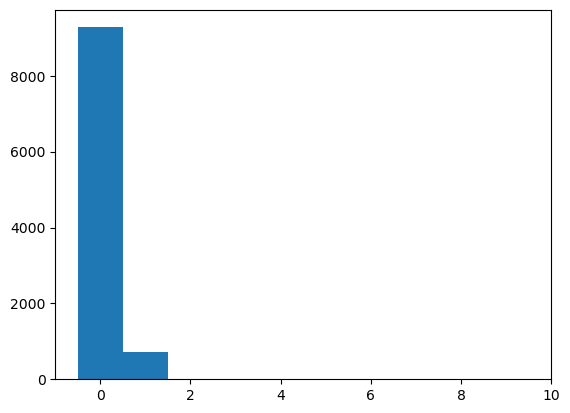

In [40]:
print(d_ensemble)
plt.figure()
plt.hist(d_ensemble, align = "left", bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

[[0.07247786287488489, 0.17326268437336326, 0.1924200277197387, 0.24650891299865707, 0.2604498202391238, 0.3033861559184673, 0.5581269220016774], [0.07247786287488489, 0.17326268437336326, 0.24650891299865707, 0.2604498202391238, 0.3033861559184673, 0.33384060603425425, 0.4152013078777467], [0.07311859150843622, 0.17326268437336326, 0.24650891299865707, 0.2604498202391238, 0.3033861559184673, 0.3311849446712214, 0.4152013078777467], [0.07311859150843622, 0.17326268437336326, 0.24650891299865707, 0.2604498202391238, 0.3033861559184673, 0.3393829349839606, 0.40609141216342665], [0.07311859150843622, 0.17326268437336326, 0.23378539827009015, 0.2604498202391238, 0.3162295477258061, 0.3393829349839606, 0.40609141216342665], [0.07311859150843622, 0.17326268437336326, 0.23378539827009015, 0.263537044857486, 0.31396484029069743, 0.3393829349839606, 0.40609141216342665], [0.06933947323192653, 0.17326268437336326, 0.23378539827009015, 0.263537044857486, 0.31396484029069743, 0.34084723933251204, 

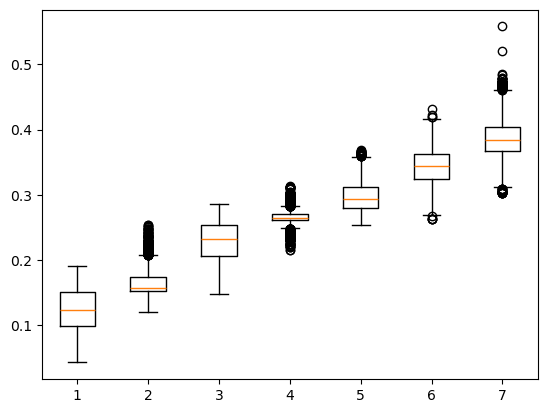

In [43]:
bpop = [] 

for current_plan in ma_random_walk: 
    bpop_this_step = []
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)
    bpop_this_step.sort()
    bpop.append(bpop_this_step)

print(bpop)

a = np.array(bpop)
print(a)

plt.figure()
plt.boxplot(a)
plt.show()